In [7]:
import pandas as pd
import geopandas as gpd
from sklearn.cluster import KMeans
from pathlib import Path
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import shape, Point
import math
from scipy.signal import fftconvolve as scipy_fft_conv
import rasterio
import rasterio.features
import rasterio.warp
import pickle
import json
import warnings
import cv2

warnings.filterwarnings("ignore")

def np_function(image):
    """
    Create a image with each pixel be the distance bewteen the pixel coordinate and the center
    """
    center = np.array([(image.shape[0])/2, (image.shape[1])/2])

    distances = np.linalg.norm(np.indices(image.shape) - center[:,None,None], axis = 0, ord=math.inf)

    return distances

def myFunction(outputShape):
    centerY, centerX = np.indices(outputShape)
    centerY = centerY - outputShape[0] // 2
    centerX = centerX - outputShape[1] // 2

    distances = np.sqrt(centerX**2 + centerY**2) + 1
    return distances

def myFunctionDistanceDugrandCercle(outputShape, earth_radius=6371.0, resolution_lon=0.0002694945852352859, resolution_lat=0.0002694945852326214):
    half_rows = outputShape[0] // 2
    half_cols = outputShape[1] // 2

    # Créer une grille de coordonnées géographiques avec les résolutions souhaitées
    latitudes = np.linspace(-half_rows * resolution_lat, half_rows * resolution_lat, outputShape[0])
    longitudes = np.linspace(-half_cols * resolution_lon, half_cols * resolution_lon, outputShape[1])
    latitudes, longitudes = np.meshgrid(latitudes, longitudes, indexing='ij')

    # Coordonnées du point central
    center_lat = latitudes[outputShape[0] // 2, outputShape[1] // 2]
    center_lon = longitudes[outputShape[0] // 2, outputShape[1] // 2]
    print(center_lat, center_lon)
    
    # Convertir les coordonnées géographiques en radians
    latitudes_rad = np.radians(latitudes)
    longitudes_rad = np.radians(longitudes)

    # Calculer la distance du grand cercle entre chaque point et le point central
    delta_lon = longitudes_rad - np.radians(center_lon)
    delta_lat = latitudes_rad - np.radians(center_lat)
    a = np.sin(delta_lat/2)**2 + np.cos(latitudes_rad) * np.cos(np.radians(center_lat)) * np.sin(delta_lon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distances = earth_radius * c
    
    return distances


def read_tif(name):
    """
    Open a satellite images and return bands, latitude and longitude of each pixel.
    """
    with rasterio.open(name) as src:
        dt = src.read()
        height = dt.shape[1]
        width = dt.shape[2]
        cols, rows = np.meshgrid(np.arange(width), np.arange(height))
        xs, ys = rasterio.transform.xy(src.transform, rows, cols)
        lons = np.array(xs)
        lats = np.array(ys)
        src.close()
    return dt, lons, lats

def find_pixel(lats, lons, lat, lon):

    lonIndex = (np.abs(lons - lon)).argmin()
    latIndex = (np.abs(lats - lat)).argmin()

    lonValues = lons.reshape(-1,1)[lonIndex]
    latValues = lats.reshape(-1,1)[latIndex]
    #print(lonValues, latValues)
    return np.where((lons == lonValues) & (lats == latValues))

In [8]:
version = 'KMEANSClustering'

dir_csv = Path(version)

dataset = pd.read_csv(dir_csv / 'dataset_2023_calibrated.csv')

In [9]:
dataset

,creneau,cluster,temp_std_0,dwpt_std_0,rhum_std_0,prcp_std_0,wdir_std_0,wspd_std_0,prec24h_std_0,dc_std_0,...,population_min_top3,fireInfluence_top1,fireInfluence_top2,fireInfluence_top3,nonCalibratedClass,calibratedProba,calibratedClass,weights_binary,weights_reg,calibratedProba2022
0,2018-01-01,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.037574,-1.644775e-17,1.315820e-17,0,0.014504,0,1.000000,1.000000,0
1,2018-01-02,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.045089,0.000000e+00,-3.947460e-17,0,0.014429,0,1.000000,1.000000,0
2,2018-01-03,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.056361,-3.618505e-17,-1.315820e-17,0,0.014317,0,1.000000,1.000000,0
3,2018-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.075148,2.302685e-17,-9.210739e-17,0,0.014133,0,1.000000,1.000000,0
4,2018-01-05,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.112721,-3.947460e-17,3.947460e-17,0,0.013772,0,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67675,2023-09-07,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.458400,1.127214e-01,1.502952e-01,1,0.036555,0,1.000000,1.000000,0
67676,2023-09-08,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.375738,2.254428e-01,1.073537e-01,1,0.035969,0,1.000000,1.000000,0
67677,2023-09-09,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.426731,1.127214e-01,8.454106e-02,1,0.051564,0,1.000000,1.000000,0
67678,2023-09-10,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0.276167,7.514761e-02,4.508857e-02,1,0.170691,1,8.824358,8.292334,0


In [17]:
meteo = [ 'dc', 
                 'ffmc',
                 'dmc',
                 'isi',
                 'bui',
                 'fwi',
 'nesterov', 'munger', 'kbdi', 'angstroem', 'daily_severity_rating',
 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'prec24h',
 'temp16', 'dwpt16', 'rhum16', 'prcp16', 'wdir16', 'wspd16', 'prec24h16',
]

topoVariables = [ 'NDVI', 'NDMI', 'NDSI', 'NDWI',
 'population',
 #'elevation'
 ]

In [11]:
len(meteo)

25

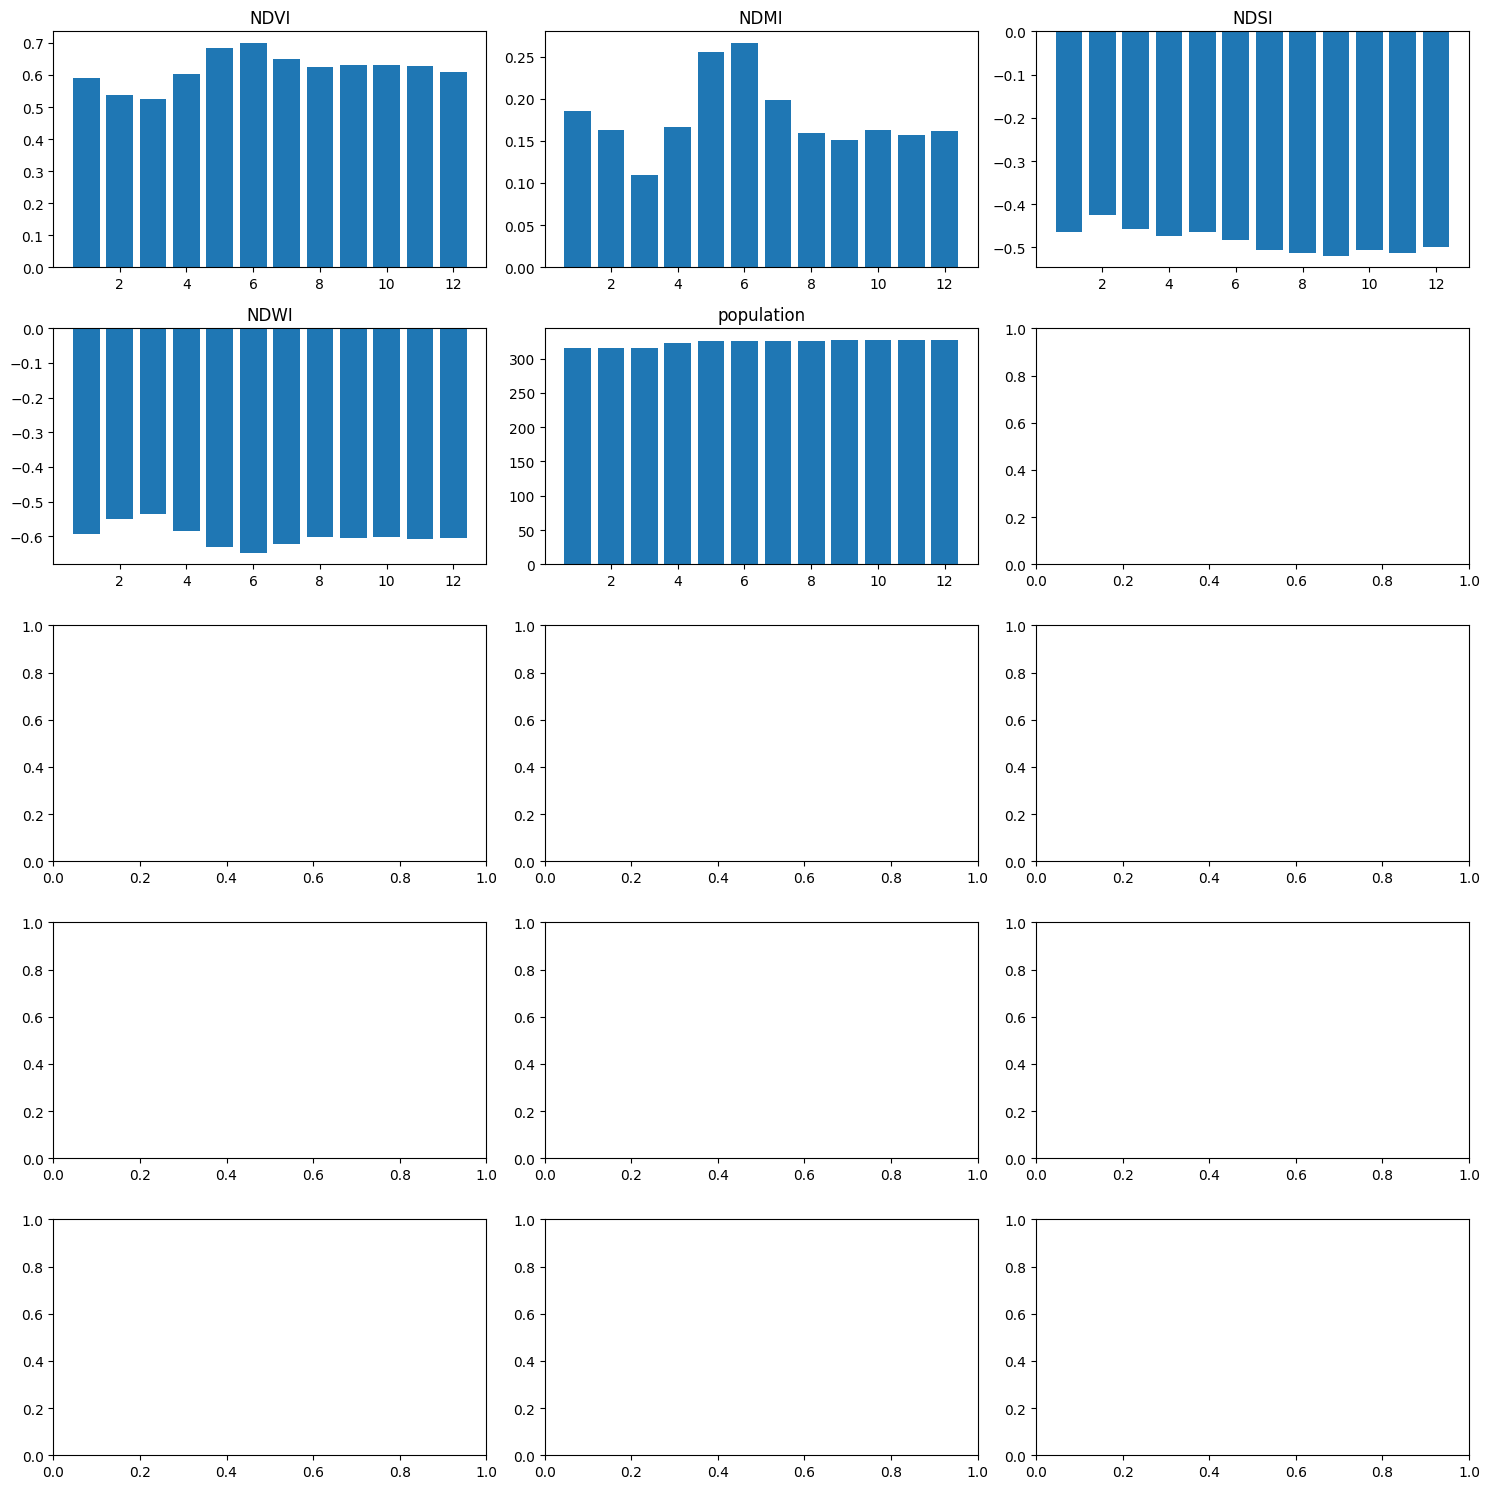

In [26]:
### Mean

fig, ax = plt.subplots(5, 3, figsize=(15,15))

i, j = 0, 0
for var in topoVariables:
    gpb = dataset.groupby('month')[var+'_mean'].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var)
    j += 1
    if j == 3:
        j = 0
        i += 1
        
plt.tight_layout()

KeyError: 'Column not found: day_since_fire_max'

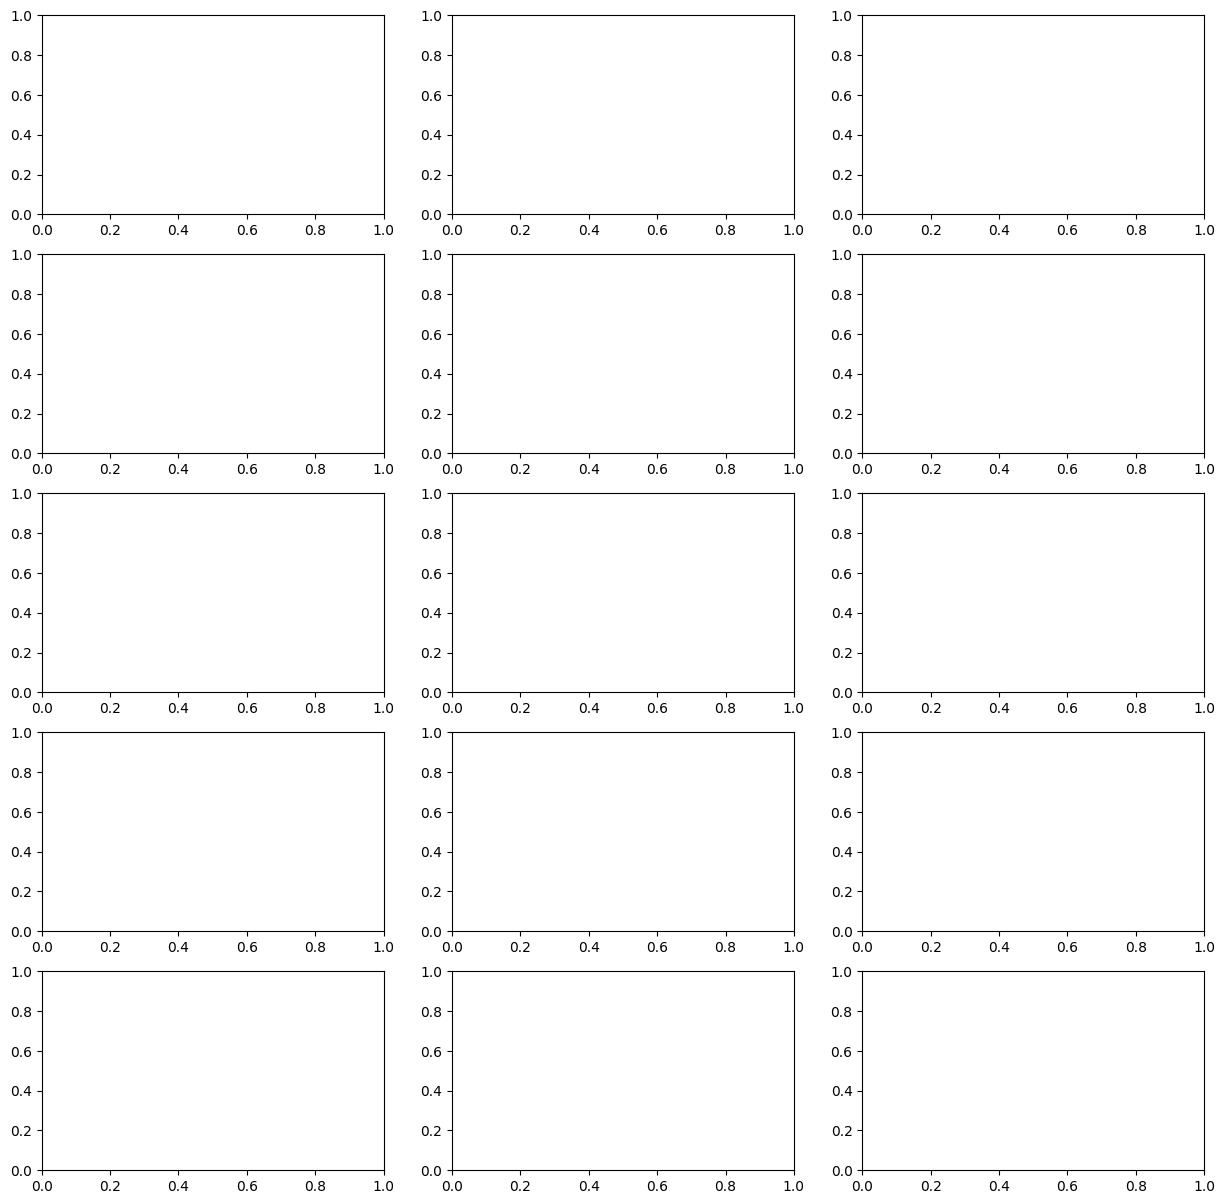

In [ ]:
### Mean

fig, ax = plt.subplots(5, 3, figsize=(15,15))

i, j = 0, 0
for var in meteo:
    gpb = dataset.groupby('month')[var+'_max'].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var)
    j += 1
    if j == 3:
        j = 0
        i += 1
        
plt.tight_layout()

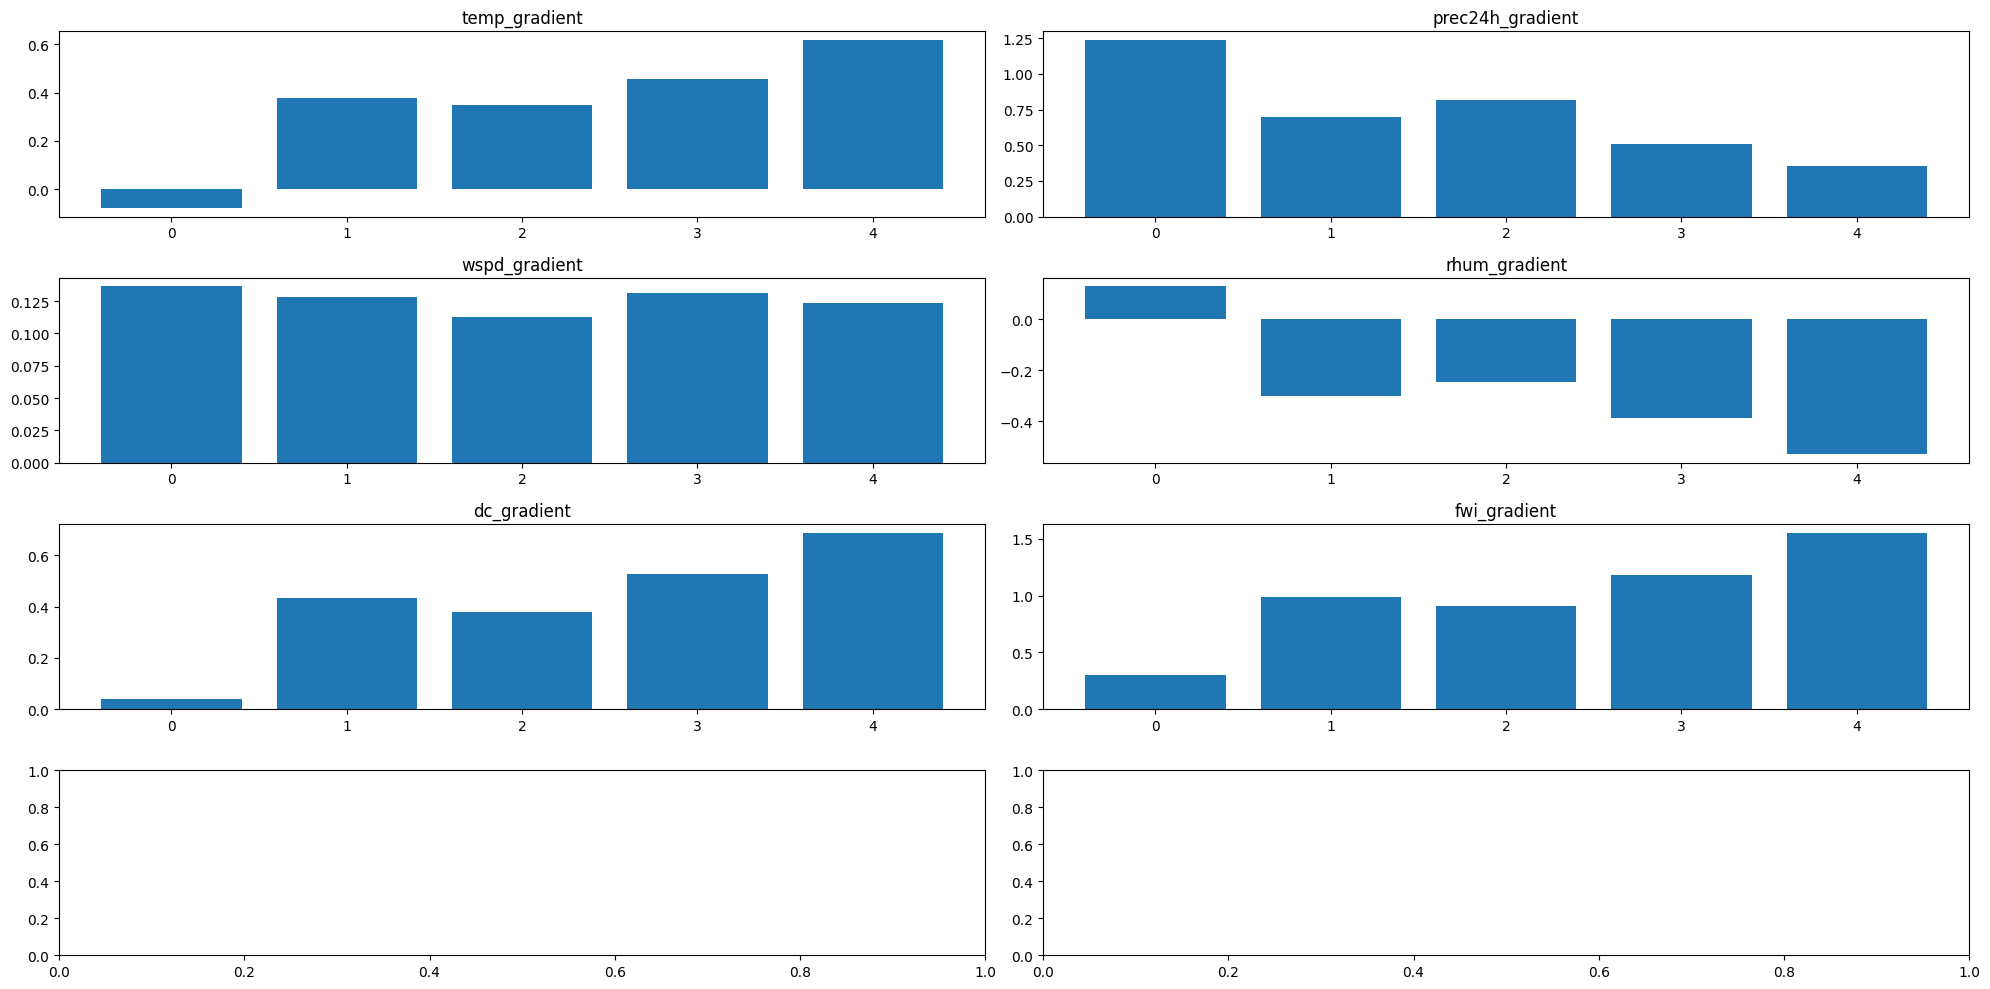

In [ ]:
### Mean

meteo = ['temp',
'prec24h',
'wspd',
'rhum',
'dc',
'fwi']

fig, ax = plt.subplots(4, 2, figsize=(20,10))

i, j = 0, 0
for var in meteo:
    gpb = dataset.groupby('classCalibrated')[var+'_0'].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var+'_gradient')
    j += 1
    if j == 2:
        j = 0
        i += 1
        
plt.tight_layout()

KeyError: 'Column not found: NumberOfCities'

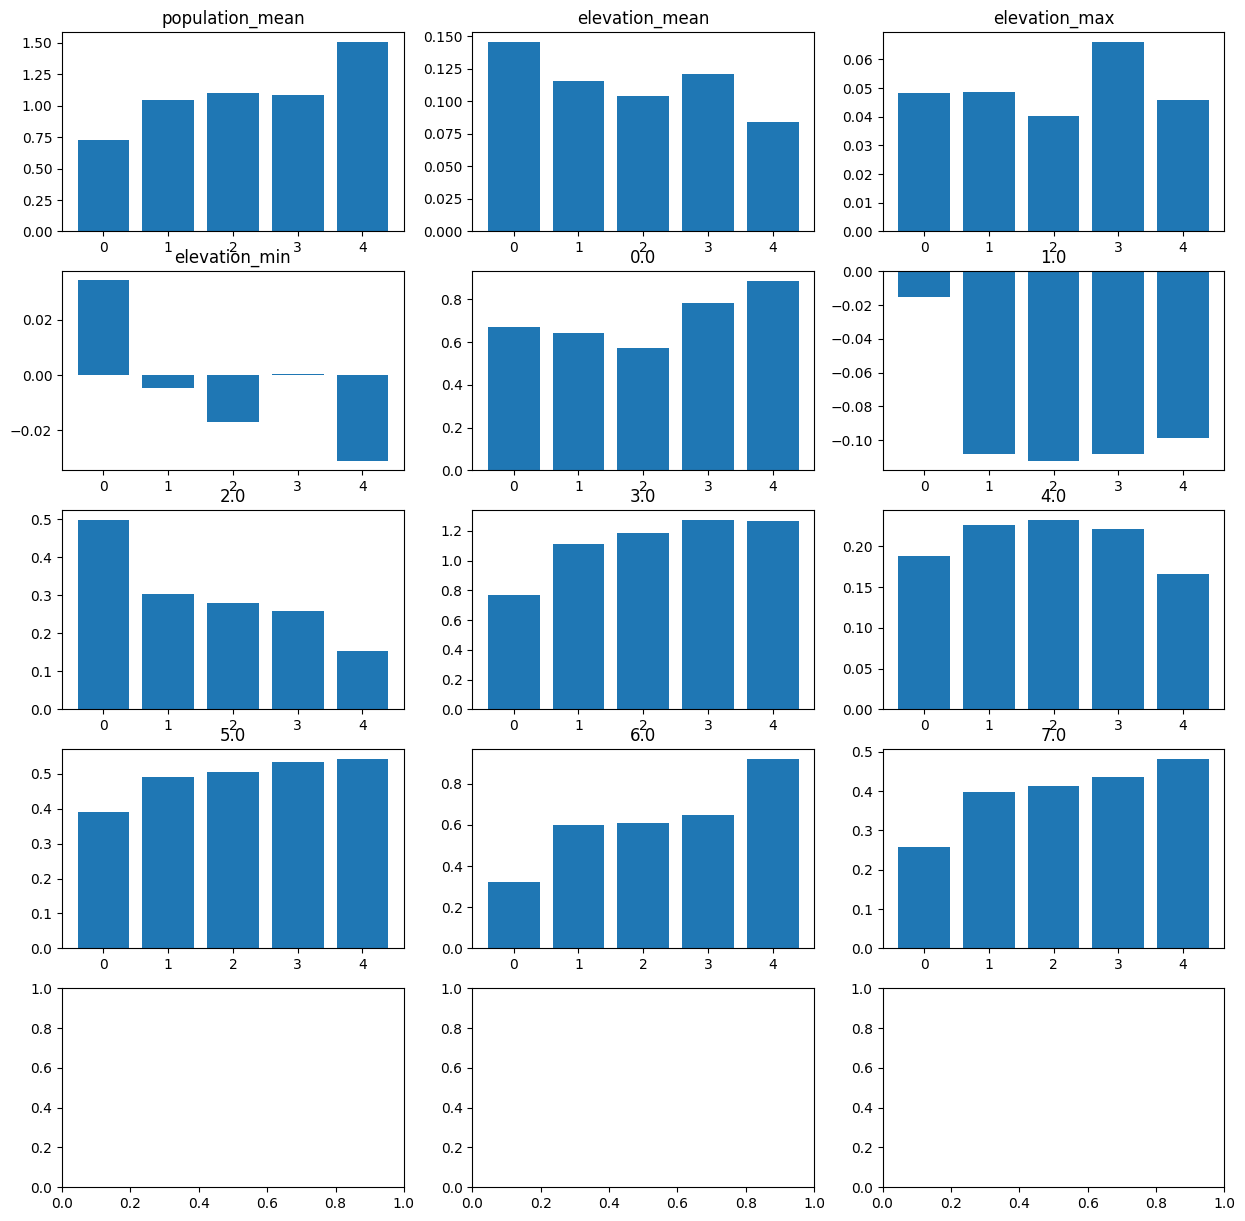

In [ ]:
topo = ['population_mean', 'elevation_mean', 'elevation_max', 'elevation_min',
            '0.0','1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0',
            'NumberOfCities']

fig, ax = plt.subplots(5, 3, figsize=(15,15))

i, j = 0, 0
for var in topo:
    gpb = dataset.groupby('classCalibrated')[var].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var)
    j += 1
    if j == 3:
        j = 0
        i += 1
        
plt.tight_layout()

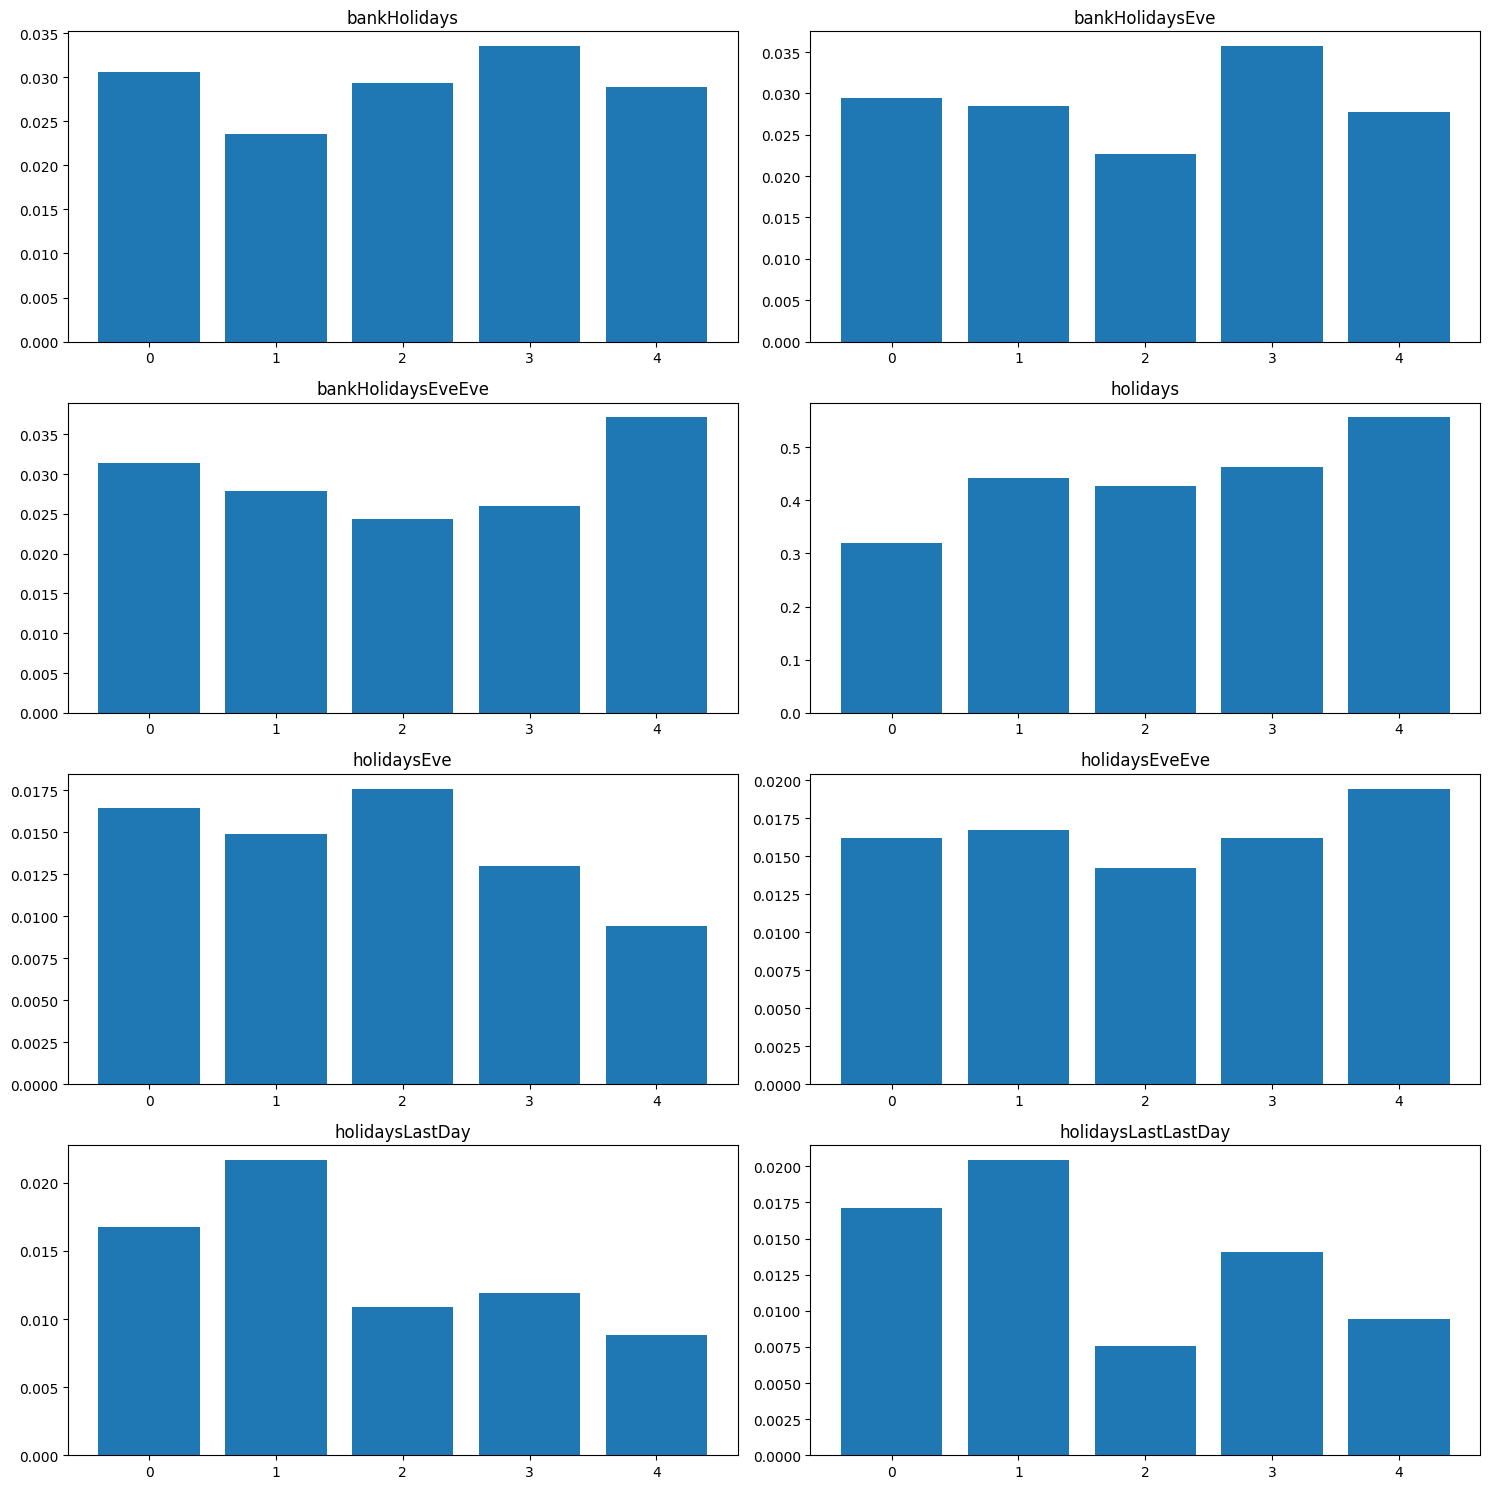

In [ ]:
holidays = ['bankHolidays', 'bankHolidaysEve', 'bankHolidaysEveEve', 'holidays',
            'holidaysEve', 'holidaysEveEve', 'holidaysLastDay', 'holidaysLastLastDay']

fig, ax = plt.subplots(4, 2, figsize=(15,15))

i, j = 0, 0
for var in holidays:
    gpb = dataset.groupby('classCalibrated')[var].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var)
    j += 1
    if j == 2:
        j = 0
        i += 1
        
plt.tight_layout()

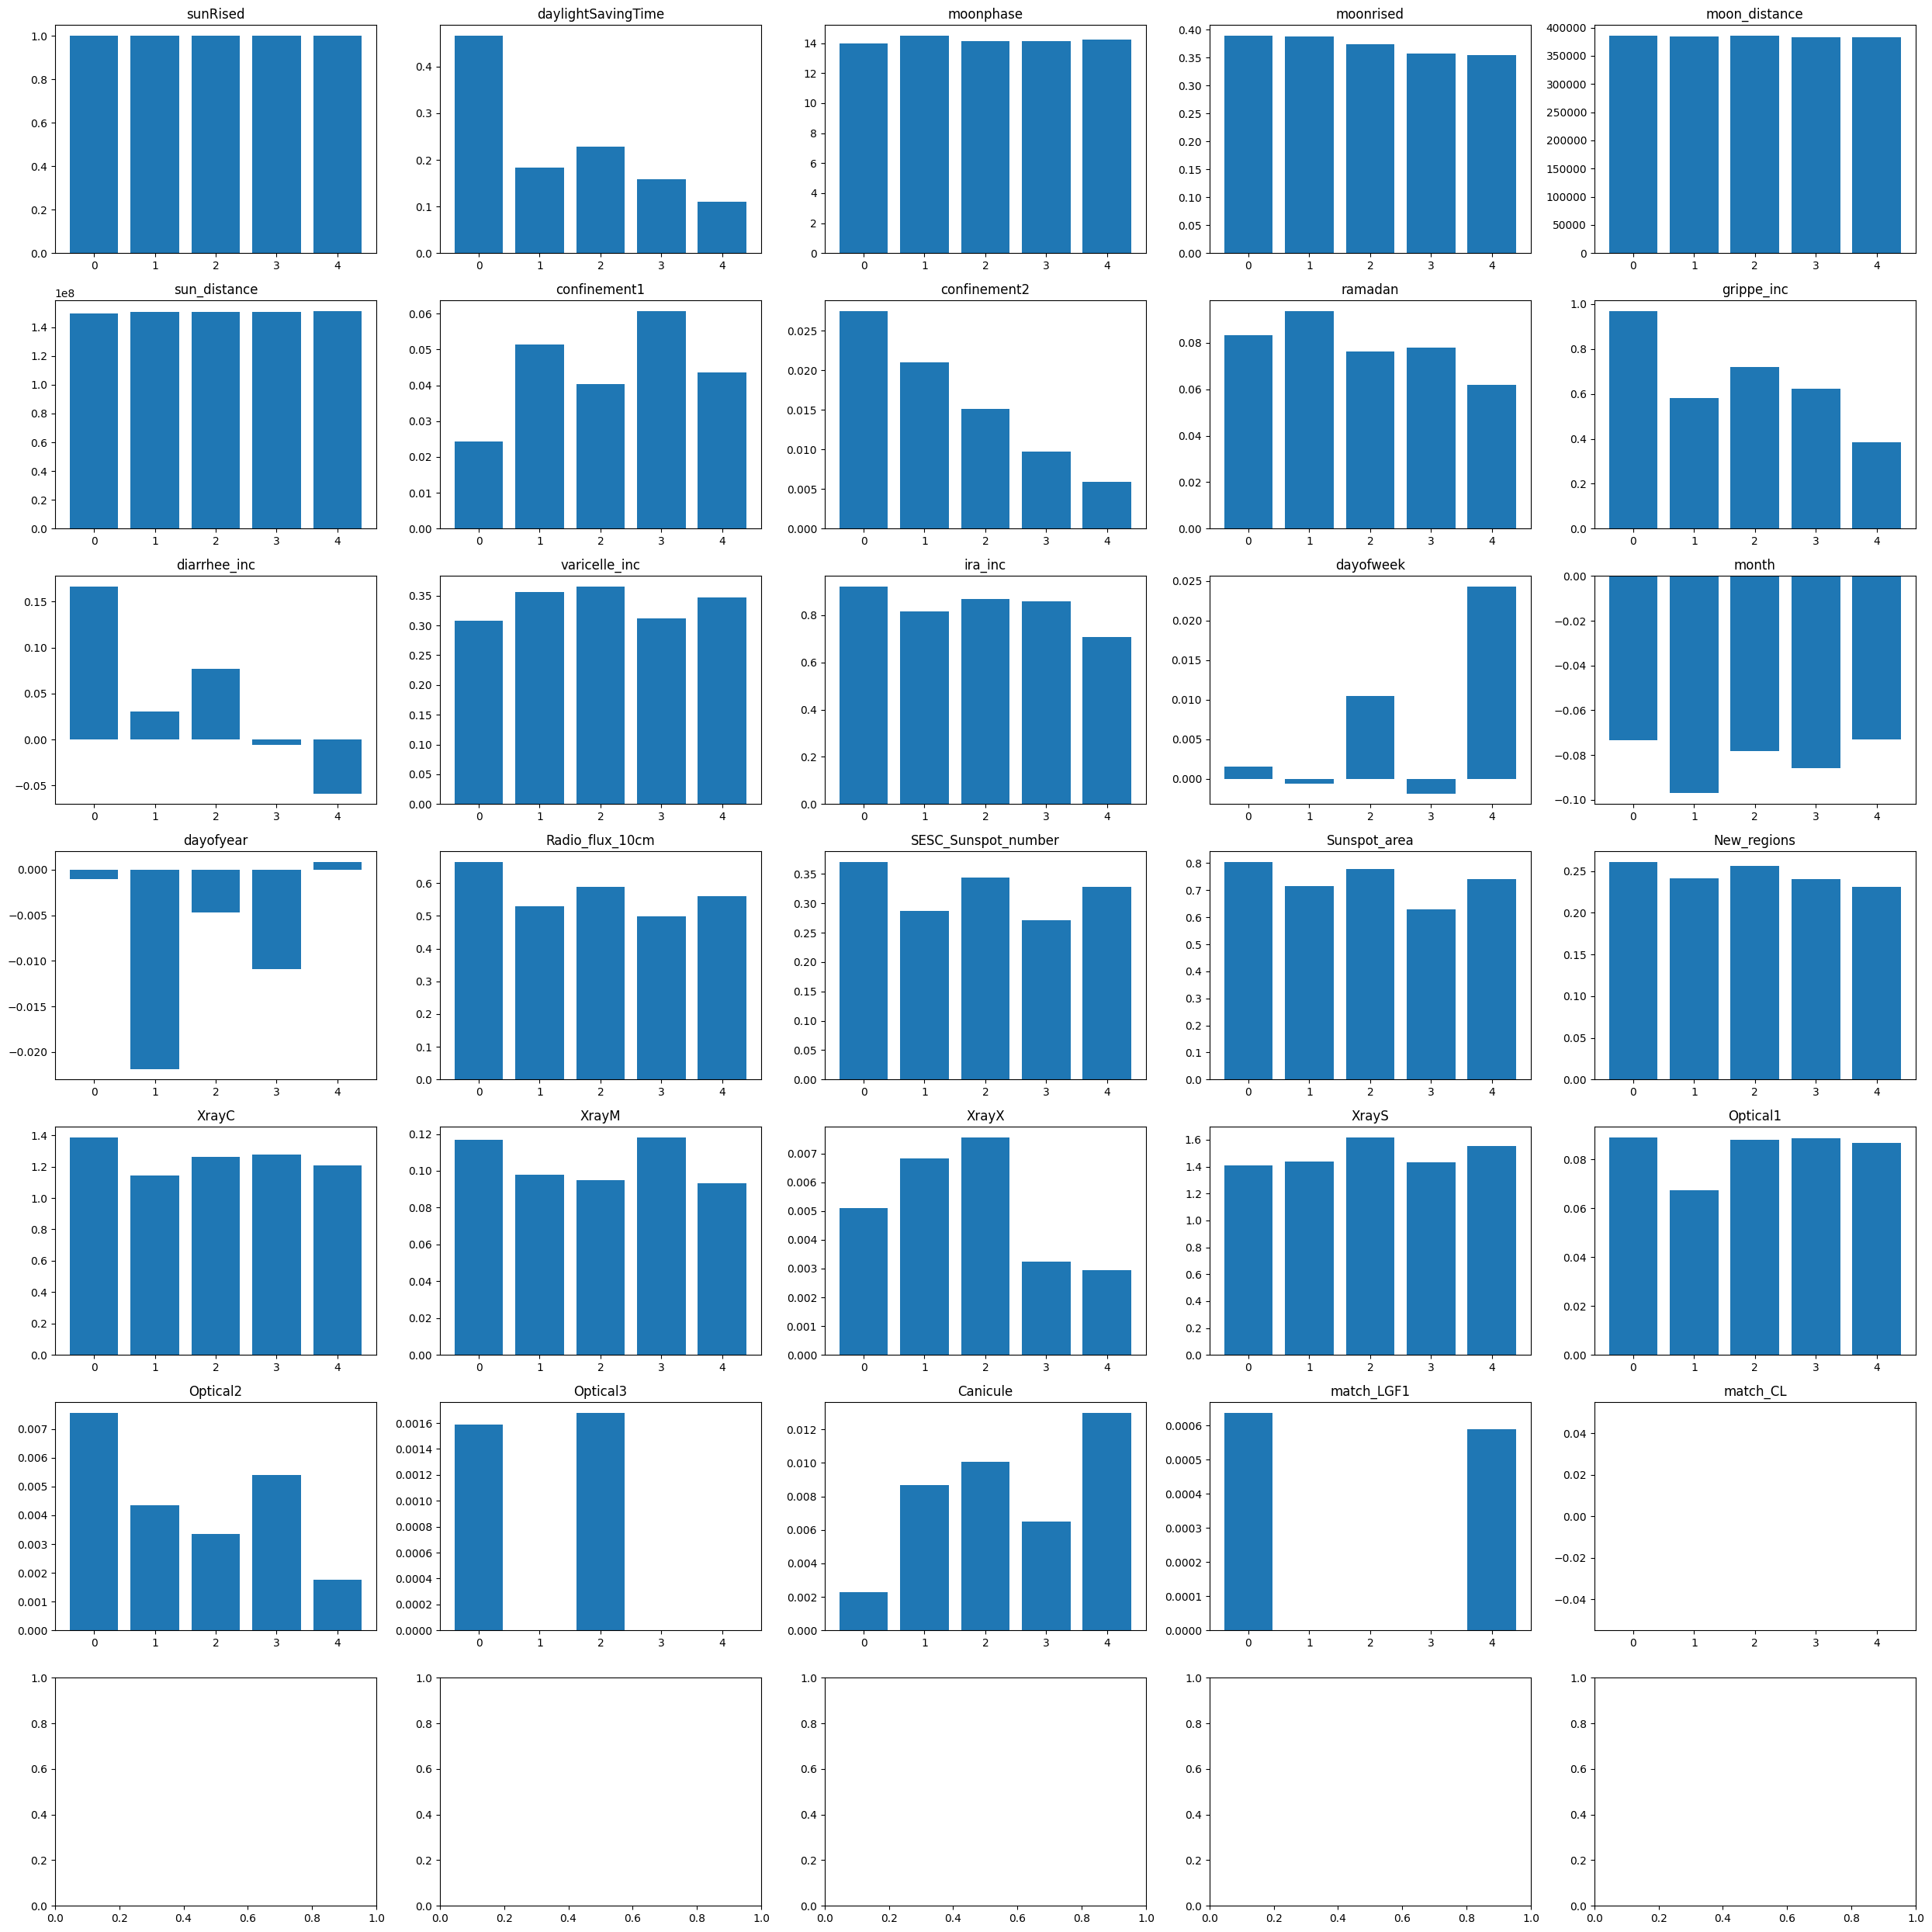

In [ ]:
other = ['sunRised', 'daylightSavingTime', 'moonphase', 'moonrised', 'moon_distance',
            'sun_distance', 'confinement1', 'confinement2', 'ramadan',
            'grippe_inc', 'diarrhee_inc',
            'varicelle_inc', 'ira_inc', 'dayofweek',
            'month', 'dayofyear', 'Radio_flux_10cm', 'SESC_Sunspot_number',
            'Sunspot_area', 'New_regions', 'XrayC', 'XrayM', 'XrayX', 'XrayS', 'Optical1', 'Optical2', 'Optical3',
            'Canicule', 'match_LGF1',  'match_CL']

fig, ax = plt.subplots(7, 5, figsize=(25,25))

i, j = 0, 0
for var in other:
    gpb = dataset.groupby('classCalibrated')[var].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var)
    j += 1
    if j == 5:
        j = 0
        i += 1
        
plt.tight_layout()

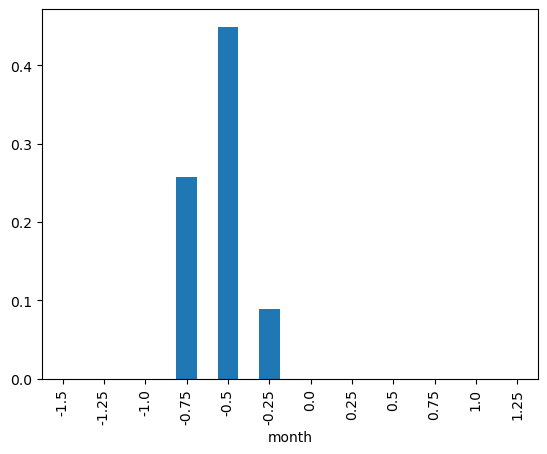

In [ ]:
gpb = dataset.groupby('month')['ramadan'].mean()
gpb.plot.bar()

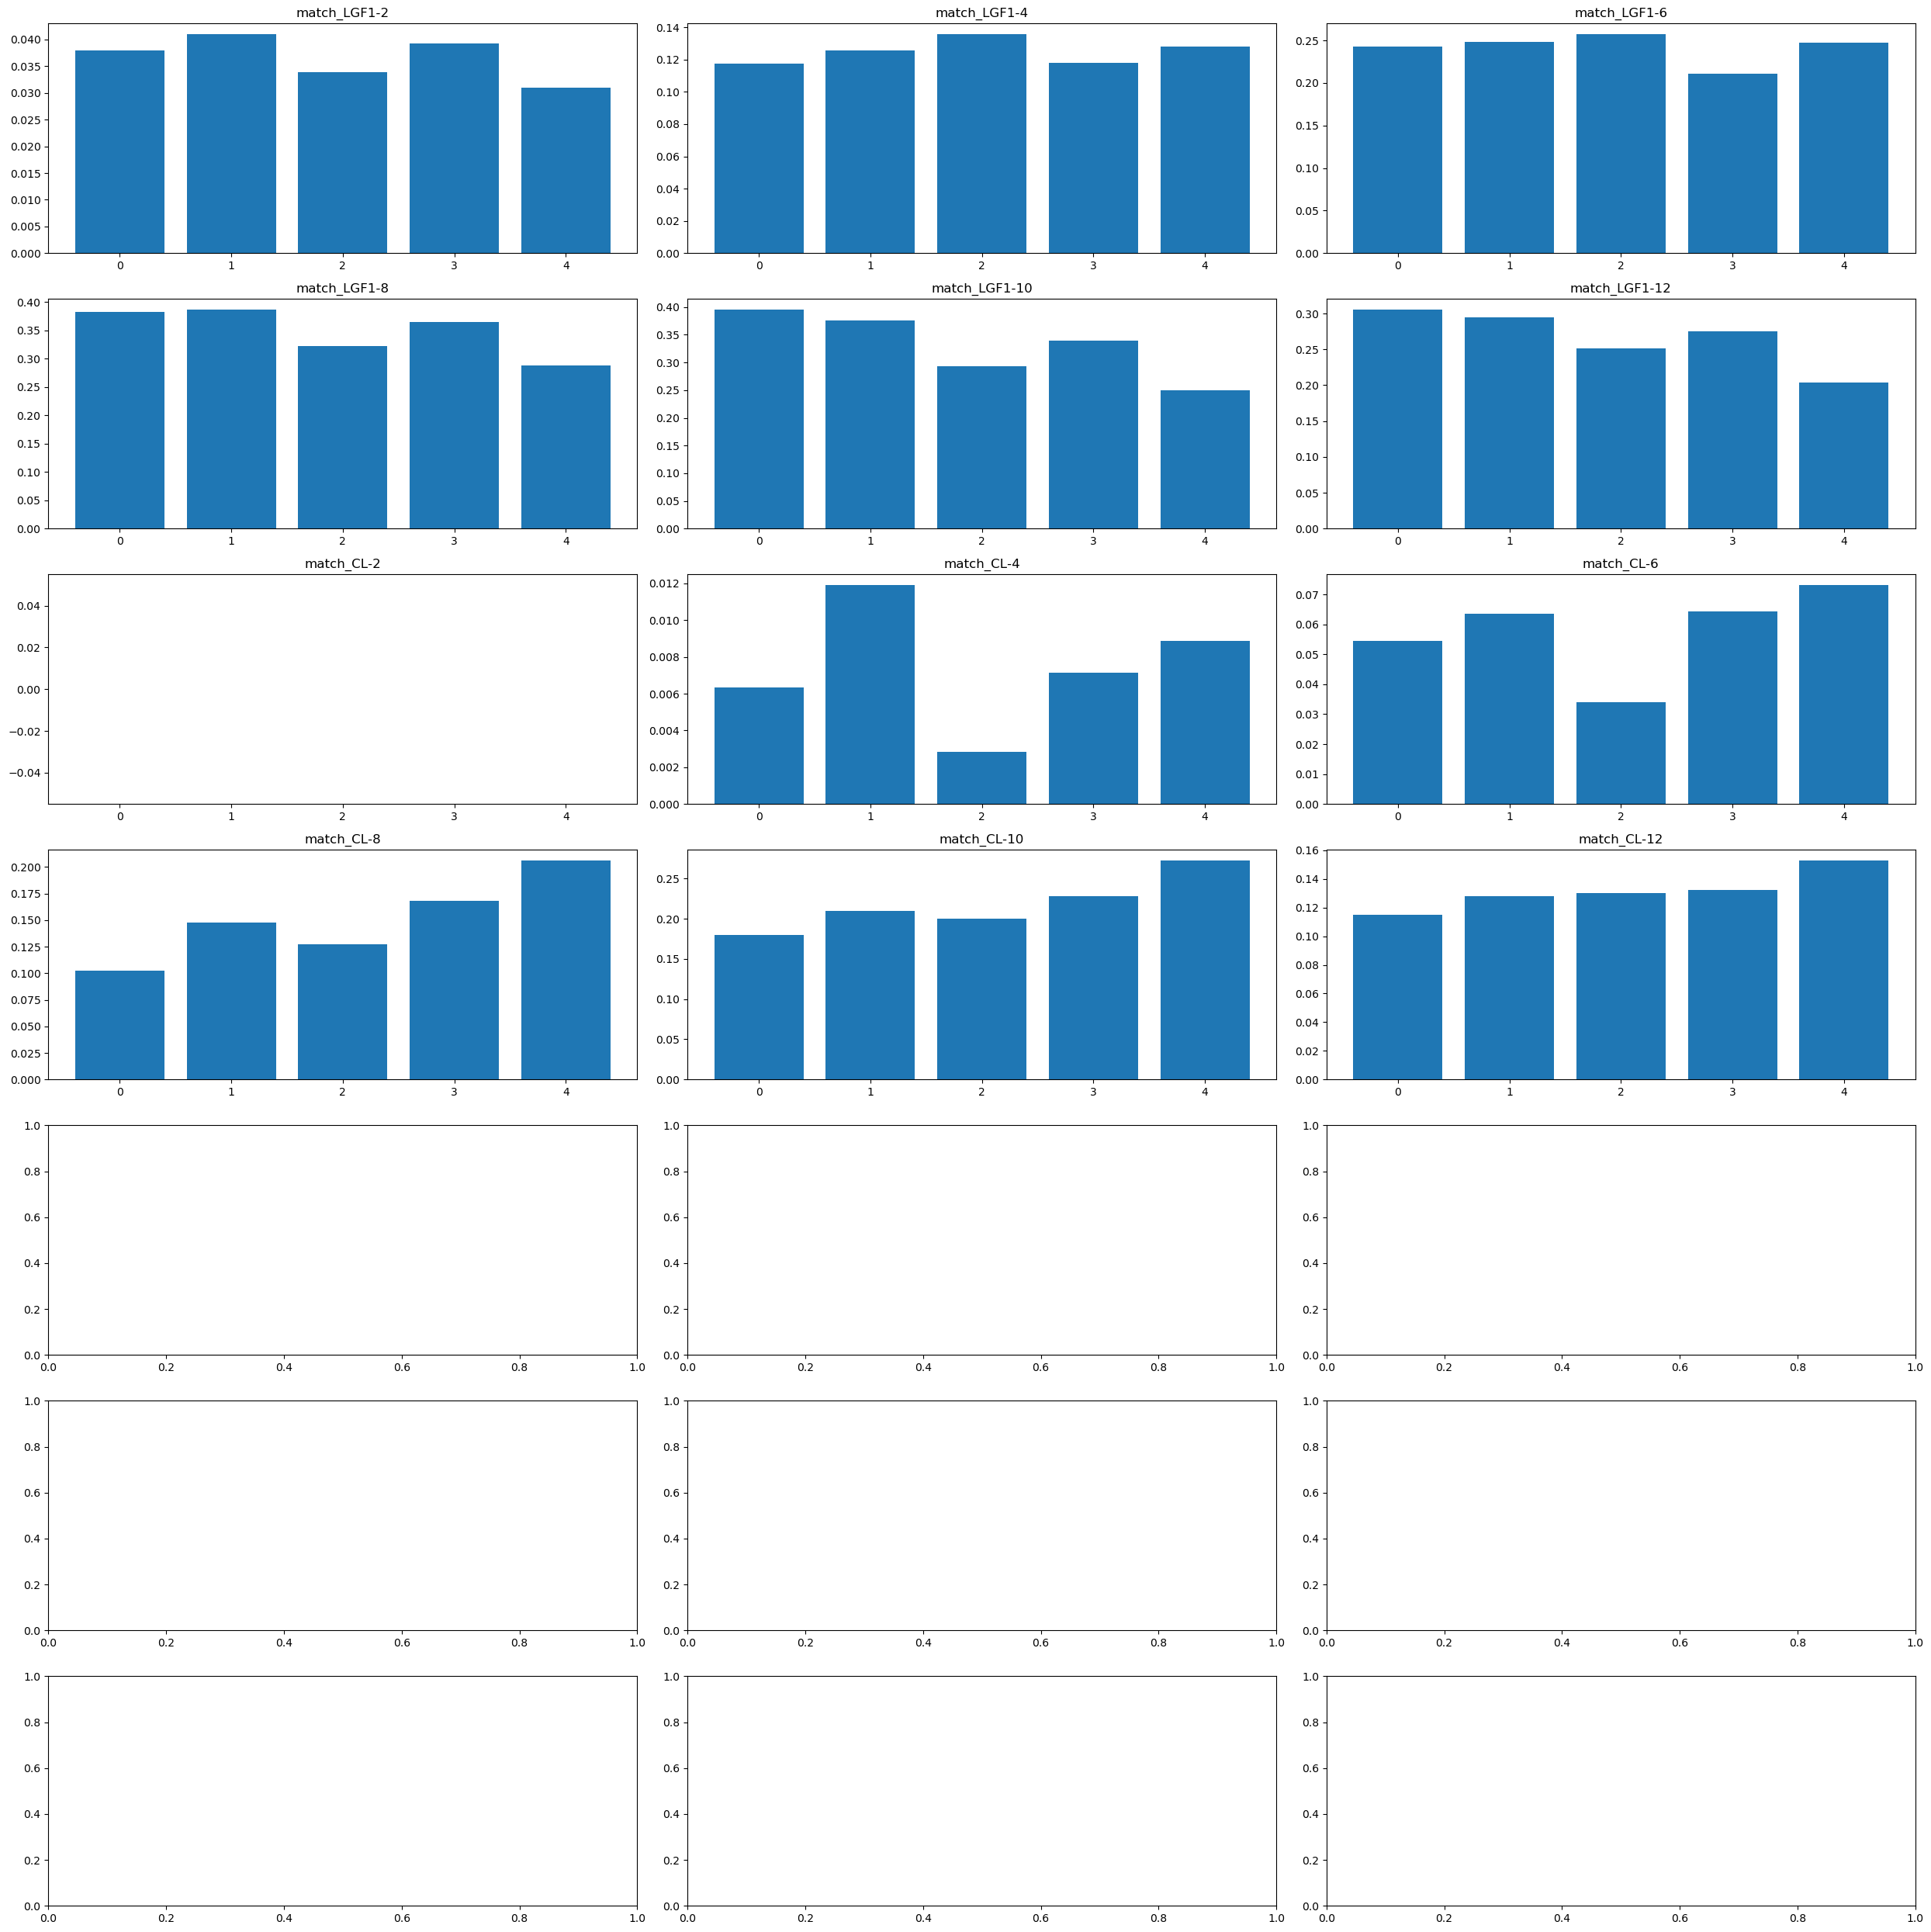

In [ ]:
other2 =  ['match_LGF1-2', 'match_LGF1-4', 'match_LGF1-6', 'match_LGF1-8', 'match_LGF1-10', 'match_LGF1-12',
            'match_CL-2', 'match_CL-4', 'match_CL-6', 'match_CL-8', 'match_CL-10','match_CL-12']

fig, ax = plt.subplots(7, 3, figsize=(25,25))

i, j = 0, 0
for var in other2:
    gpb = dataset.groupby('class')[var].mean()
    ax[i][j].bar(gpb.index, gpb.values)
    ax[i][j].set_title(var)
    j += 1
    if j == 3:
        j = 0
        i += 1
        
plt.tight_layout()